<a href="https://colab.research.google.com/github/RcrvzM/DM_PROYECTO-FINAL/blob/main/DM_Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 🔧 Instalar Java y Spark desde fuentes oficiales
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Descargar Spark directamente
!curl -L -o spark.tgz https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xzf spark.tgz

# Instalar findspark
!pip install -q findspark


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  285M  100  285M    0     0  18.9M      0  0:00:15  0:00:15 --:--:-- 21.3M


In [4]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
findspark.init()


In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Flujo_ETL_BI_Colab") \
    .getOrCreate()

spark


In [6]:
import pandas as pd

def descargar_datos():
    url = "https://people.sc.fsu.edu/~jburkardt/data/csv/hw_200.csv"
    df = pd.read_csv(url)
    print("✅ Datos descargados")
    return df

df_pandas = descargar_datos()
df_pandas.head()


✅ Datos descargados


,Index,"Height(Inches)""","""Weight(Pounds)"""
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30


In [14]:
# Limpiar columnas de pandas y guardar temporal
df_pandas.columns = df_pandas.columns.str.strip().str.replace('"', '').str.replace(' ', '_')
df_pandas = df_pandas.dropna()

# Guardar en CSV temporal
df_pandas.to_csv("datos_limpios.csv", index=False)


In [15]:
df_spark = spark.read.option("header", True).option("inferSchema", True).csv("datos_limpios.csv")
df_spark.printSchema()
df_spark.show(5)


root
 |-- Index: integer (nullable = true)
 |-- Height(Inches): double (nullable = true)
 |-- Weight(Pounds): double (nullable = true)

+-----+--------------+--------------+
|Index|Height(Inches)|Weight(Pounds)|
+-----+--------------+--------------+
|    1|         65.78|        112.99|
|    2|         71.52|        136.49|
|    3|          69.4|        153.03|
|    4|         68.22|        142.34|
|    5|         67.79|         144.3|
+-----+--------------+--------------+
only showing top 5 rows



In [16]:
from pyspark.sql.functions import avg

df_spark.select(
    avg("Height(Inches)").alias("Promedio_Altura"),
    avg("Weight(Pounds)").alias("Promedio_Peso")
).show()


+-----------------+-----------------+
|  Promedio_Altura|    Promedio_Peso|
+-----------------+-----------------+
|67.94979999999998|127.2219500000001|
+-----------------+-----------------+



In [17]:
from pyspark.sql.functions import when

df_altura = df_spark.withColumn(
    "Rango_Altura",
    when(df_spark["Height(Inches)"] < 60, "Bajo")
    .when(df_spark["Height(Inches)"] < 68, "Promedio")
    .otherwise("Alto")
)

df_altura.groupBy("Rango_Altura").count().show()


+------------+-----+
|Rango_Altura|count|
+------------+-----+
|    Promedio|  103|
|        Alto|   97|
+------------+-----+



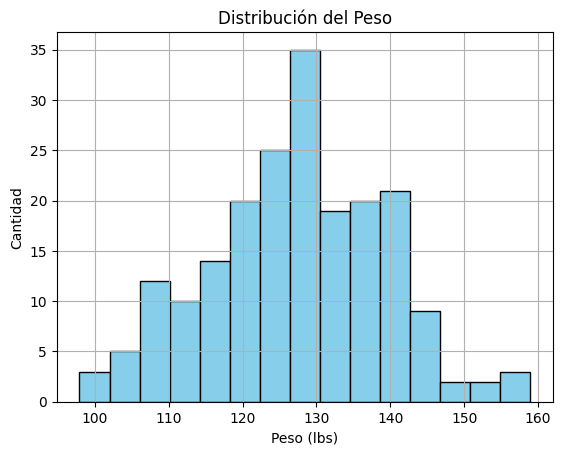

In [18]:
df_plot = df_spark.toPandas()

import matplotlib.pyplot as plt

plt.hist(df_plot["Weight(Pounds)"], bins=15, color="skyblue", edgecolor="black")
plt.title("Distribución del Peso")
plt.xlabel("Peso (lbs)")
plt.ylabel("Cantidad")
plt.grid(True)
plt.show()
